## Download dataset

In [1]:
!if [ -e celeba ]; \
then echo "Downloaded and Prepared!"; \
else wget --load-cookies cookies.txt 'https://docs.google.com/uc?export=download&confirm='"$(wget --save-cookies cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=0B7EVK8r0v71pZjFTYXZWM3FlRnM' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')"'&id=0B7EVK8r0v71pZjFTYXZWM3FlRnM' -O img_align_celeba.zip; \
unzip -q img_align_celeba; \
mkdir celeba; \
mv img_align_celeba celeba/imgs; \
fi;

--2018-11-02 20:28:47--  https://docs.google.com/uc?export=download&id=0B7EVK8r0v71pZjFTYXZWM3FlRnM
Resolving docs.google.com (docs.google.com)... 74.125.20.101, 74.125.20.113, 74.125.20.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.20.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘STDOUT’

-                       [ <=>                ]   3.16K  --.-KB/s    in 0s      

2018-11-02 20:28:48 (26.9 MB/s) - written to stdout [3238]

--2018-11-02 20:28:48--  https://docs.google.com/uc?export=download&confirm=AvJi&id=0B7EVK8r0v71pZjFTYXZWM3FlRnM
Resolving docs.google.com (docs.google.com)... 74.125.20.101, 74.125.20.113, 74.125.20.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.20.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-84-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ole2ienf03qi5r7gbu2rb6m9njdi

### Install and import torch

In [1]:
# Install part
!pip install torch torchvision matplotlib tqdm numpy

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.autograd import Variable
import torch.optim as optim

import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pdb

# Instruct matplotlib to draw inline
%matplotlib inline

# See if the cuda is avaliable and store it in device
assert torch.cuda.is_available(), "Change to gpu"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Dataset section
import os
import gzip
import tarfile
import gc
from PIL import Image

# from IPython.core.ultratb import AutoFormattedTB
# __ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)


### Image functions

In [0]:
def draw_image(img, title="GAN"):
    fig = plt.figure(1)
    ax1 = fig.add_subplot(1, 1, 1)
    plt.axis('off')
    # generated_image.cpu().detach().numpy()
    image = img.cpu().detach()
    indx = np.random.randint(0, 20)
    image = image[indx].squeeze(0)
    # print('image', image.shape)
    # image = image.numpy().squeeze(0)      
    unloader = transforms.ToPILImage()
    image = unloader(image)
    ax1.grid(False)
    plt.title(title)
    plt.imshow(image)
    plt.pause(0.001)


In [4]:
"""
input = torch.randn(1, 1024, 4, 4)
upsample1 = nn.ConvTranspose2d(1024, 512, 2, stride=2, padding=0)
upsample2 = nn.ConvTranspose2d(512, 256, 2, stride=2, padding=0)
upsample3 = nn.ConvTranspose2d(256, 128, 2, stride=2, padding=0)
upsample4 = nn.ConvTranspose2d(128, 3, 2, stride=2, padding=0)
h=upsample1(input)
h=upsample2(h)
h=upsample3(h)
h=upsample4(h)
h.shape
"""

'\ninput = torch.randn(1, 1024, 4, 4)\nupsample1 = nn.ConvTranspose2d(1024, 512, 2, stride=2, padding=0)\nupsample2 = nn.ConvTranspose2d(512, 256, 2, stride=2, padding=0)\nupsample3 = nn.ConvTranspose2d(256, 128, 2, stride=2, padding=0)\nupsample4 = nn.ConvTranspose2d(128, 3, 2, stride=2, padding=0)\nh=upsample1(input)\nh=upsample2(h)\nh=upsample3(h)\nh=upsample4(h)\nh.shape\n'

In [5]:
"""
input = torch.randn(1, 3, 64, 64)

dsample1 = nn.Conv2d(3, 128, 2, stride=2, padding=0)
dsample2 = nn.Conv2d(128, 256, 2, stride=2, padding=0)
dsample3 = nn.Conv2d(256, 512, 2, stride=2, padding=0)
dsample4 = nn.Conv2d(512, 1024, 2, stride=2, padding=0)
h=dsample1(input)
h=dsample2(h)
h=dsample3(h)
h=dsample4(h)
h.shape
h.view(-1).shape
"""

'\ninput = torch.randn(1, 3, 64, 64)\n\ndsample1 = nn.Conv2d(3, 128, 2, stride=2, padding=0)\ndsample2 = nn.Conv2d(128, 256, 2, stride=2, padding=0)\ndsample3 = nn.Conv2d(256, 512, 2, stride=2, padding=0)\ndsample4 = nn.Conv2d(512, 1024, 2, stride=2, padding=0)\nh=dsample1(input)\nh=dsample2(h)\nh=dsample3(h)\nh=dsample4(h)\nh.shape\nh.view(-1).shape\n'

In [6]:
"""
input = torch.randn(10, 3, 64, 64)
input.norm(2, dim=1).shape
"""

'\ninput = torch.randn(10, 3, 64, 64)\ninput.norm(2, dim=1).shape\n'

### DCGAN

### Generator

In [0]:
class DCGen(nn.Module):
  def __init__(self):
    super(DCGen, self).__init__()
 
    self.full_conn = nn.Linear(100, 16384)

    # DCGAN architecture Figure 1 from paper
    self.dcgen = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, 2, stride=2, padding=0),
            #nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 2, stride=2, padding=0),
            #nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 2, stride=2, padding=0),
            #nn.BatchNorm2d(128),
            nn.ReLU(),    
            nn.ConvTranspose2d(128, 3, 2, stride=2, padding=0),
            #nn.BatchNorm2d(64),
            nn.Sigmoid()
    )
    
  def forward(self, input):
    
    fully_connected = self.full_conn(input)
    
    fully_connected = fully_connected.view(input.shape[0], 1024, 4, 4)
    
    output = self.dcgen(fully_connected)
    
    return output
    

### Discriminator

In [0]:
class DCDis(nn.Module):
  def __init__(self):
    super(DCDis, self).__init__()
 
    self.full_conn = nn.Sequential(
        nn.Linear(16384, 1) #,
        # nn.ReLU(),
        # nn.Linear(100, 1)
    )

    # DCGAN architecture Figure 1 from paper
    self.dcdis = nn.Sequential(
            nn.Conv2d(3, 128, 2, stride=2, padding=0),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 2, stride=2, padding=0),
            #nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 2, stride=2, padding=0),
            #nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),    
            nn.Conv2d(512, 1024, 2, stride=2, padding=0),
            #nn.BatchNorm2d(1024),
            #nn.LeakyReLU(0.2), 
    )
    
  def forward(self, input):
    
    dcdis = self.dcdis(input)
    dcdis = dcdis.view(input.shape[0], 16384)
    
    output = self.full_conn(dcdis)
    return output
    

### Load Data

In [0]:
class CelebaDataset(Dataset):
  def __init__(self, root, size=128, train=True):
    super(CelebaDataset, self).__init__()
    self.dataset_folder = torchvision.datasets.ImageFolder(os.path.join(root) ,transform = transforms.Compose([transforms.Resize((size,size)),transforms.ToTensor()]))
    # print ('DB size',len(self.dataset_folder))
    
  def __getitem__(self,index):
    img = self.dataset_folder[index]
    return img[0]
 
  def __len__(self):
    return len(self.dataset_folder)

### Loss Function

In [0]:
#### Discriminator loss function
class DisLoss(nn.Module):
  def __init__(self, input=None, target=None, weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='elementwise_mean', dis=None):
    super(DisLoss, self).__init__()
    self.__dict__.update(locals())
  
  def forward(self, x, x_tild, x_hat):
    loss = torch.tensor([0.0]).cuda()
    # First part of the loss equation
    first = self.dis(x_tild) - self.dis(x)
    dis_xhat = self.dis(x_hat)
    # print ('dloss', x_tild.shape, x.shape, first.shape, dis_xhat.shape)
    gradient = torch.autograd.grad(outputs=dis_xhat, inputs=x_hat, create_graph=True, retain_graph=True, only_inputs=True, grad_outputs=torch.ones(dis_xhat.size()).cuda())[0]
    gradient_penalty = torch.pow((gradient.norm(2, dim=1) - 1), 2) * lambda1
    # print (first.shape, gradient_penalty.shape)
    loss = first + gradient_penalty.mean()
    
    return loss.mean()
  
#### Generator loss function
class GenLoss(nn.Module):
  def __init__(self, input=None, target=None, weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='elementwise_mean', dis=None, gen=None):
    super(GenLoss, self).__init__()
    self.__dict__.update(locals())
  
  def forward(self, z):
    loss = torch.tensor([0.0]).cuda()
    # First part of the loss equation
    loss = self.dis(self.gen(z))
    
    return -1 * loss.mean()

### Training Loop

epoch:0, dloss:11053.9883, gloss:30888.5879:   2%|▏         | 1013/50650 [24:24<19:55:38,  1.45s/it]

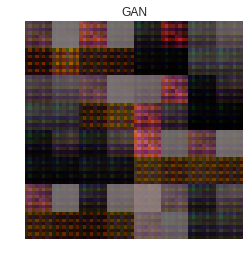

epoch:2, dloss:8154.1890, gloss:27207.0527:   6%|▌         | 3039/50650 [1:13:03<19:06:55,  1.45s/it]

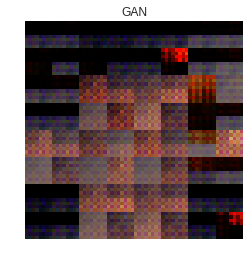

epoch:4, dloss:-1592.3158, gloss:559.8898:  10%|█         | 5065/50650 [2:01:48<18:22:40,  1.45s/it]

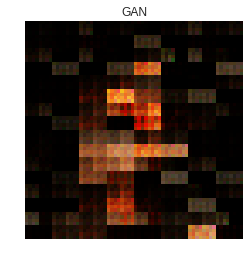

epoch:6, dloss:87.2409, gloss:2844.1880:  14%|█▍        | 7091/50650 [2:50:44<17:28:15,  1.44s/it]

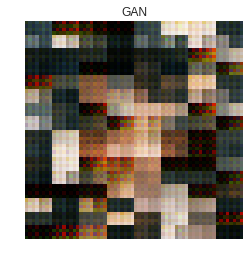

epoch:8, dloss:74.1590, gloss:-966.3659:  18%|█▊        | 9117/50650 [3:39:46<16:47:26,  1.46s/it]

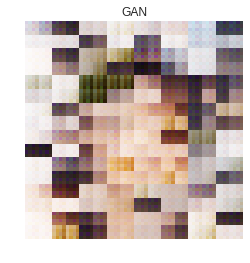

epoch:10, dloss:-45466.9609, gloss:-66089.4375:  22%|██▏       | 11143/50650 [4:28:49<15:50:55,  1.44s/it]

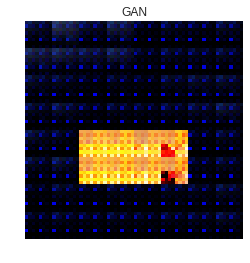

epoch:12, dloss:-376.0972, gloss:2881.4111:  26%|██▌       | 13169/50650 [5:17:48<15:09:51,  1.46s/it]

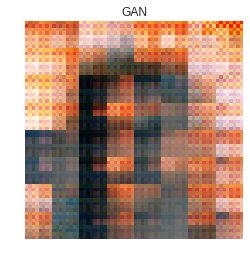

epoch:14, dloss:-130.2003, gloss:8906.2324:  30%|███       | 15195/50650 [6:06:43<14:16:54,  1.45s/it]

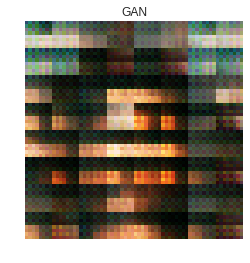

epoch:16, dloss:-20.5135, gloss:204.6070:  34%|███▍      | 17221/50650 [6:55:42<13:25:57,  1.45s/it]

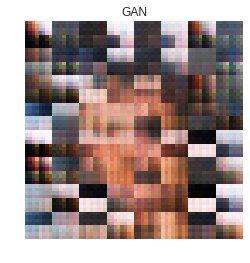

epoch:18, dloss:-50.4849, gloss:443.2390:  38%|███▊      | 19247/50650 [7:44:35<12:28:44,  1.43s/it]

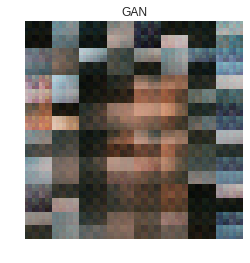

epoch:20, dloss:-624.8171, gloss:4907.8057:  42%|████▏     | 21273/50650 [8:33:23<11:52:05,  1.45s/it]

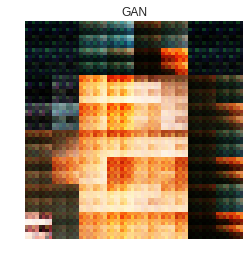

epoch:22, dloss:-85.2509, gloss:415.9116:  46%|████▌     | 23299/50650 [9:22:26<11:03:52,  1.46s/it]

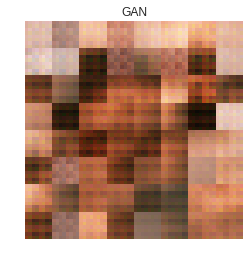

epoch:24, dloss:-7881.9785, gloss:-387725.4688:  50%|█████     | 25325/50650 [10:11:24<10:14:22,  1.46s/it]

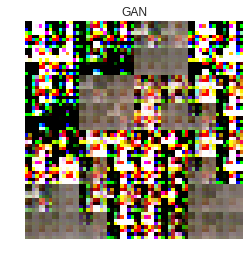

epoch:26, dloss:542.2317, gloss:-16992.9199:  54%|█████▍    | 27351/50650 [11:00:20<9:24:22,  1.45s/it]

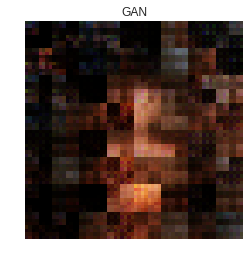

epoch:28, dloss:714.0988, gloss:-6695.8315:  58%|█████▊    | 29377/50650 [11:49:18<8:34:43,  1.45s/it]

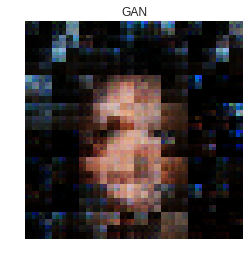

epoch:29, dloss:1004.3583, gloss:-13305.9551:  58%|█████▊    | 29414/50650 [11:50:14<8:35:29,  1.46s/it]

In [0]:
# Hyperparameters
lambda1 = 10
beta1 = 0.5
beta2 = 0.999
critic_iters = 1
learning_rate = 0.0002
batch_size = 200

batch_norm_decay = 0.9
batch_norm_epsilon = 1e-5

z_size = 100
epochs = 50

#initialize your generator and discriminator models
gen_model = DCGen()
gen_model = gen_model.cuda()
dis_model = DCDis()
dis_model = dis_model.cuda()

#initialize separate optimizer for both gen and disc
gen_optimizer = optim.Adam(gen_model.parameters(), lr=learning_rate, betas=(beta1, beta2), eps = batch_norm_epsilon, weight_decay=batch_norm_decay)
dis_optimizer = optim.Adam(dis_model.parameters(), lr=learning_rate, betas=(beta1, beta2), eps = batch_norm_epsilon, weight_decay=batch_norm_decay)

#initialize your dataset and dataloader

# Load the training data in this case it Celebs dataset
train_dataset = CelebaDataset('celeba', train=True, size=64)

# Get the training data in a mini-batch
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
    shuffle=False, num_workers=0, pin_memory=True)
 
# Define the original seed image  
z = torch.rand(batch_size, z_size).cuda()

# Define the custom loss function
dloss_func = DisLoss(dis=dis_model)
gloss_func = GenLoss(dis=dis_model, gen=gen_model)

# Append the loss to plot
dloss_list = []
gloss_list = []

# Progress
loop = tqdm(total=len(train_loader)*epochs, position=0)

for e in range(epochs):
  for true_img in train_loader:
 
    #train discriminator#
    true_img = true_img.cuda()
    #because you want to be able to backprop through the params in discriminator 
    for p in dis_model.parameters():
      p.requires_grad = True
 
    for n in range(critic_iters):
      dis_optimizer.zero_grad()
      z = -1 * torch.rand(true_img.shape[0], z_size).cuda() + 1
      epsilon = torch.empty(1).uniform_(0, 1).cuda()
      x_tild = gen_model(z)
      # x_tild = x_tild.cuda()
      # print(true_img.shape, x_tild.shape)
      x_hat = epsilon * true_img + (1-epsilon) * x_tild
      x_hat = Variable(x_hat, requires_grad=True).cuda()
      dloss = dloss_func(true_img, x_tild, x_hat)
      # print ('loss', dloss.shape, dloss)
      dloss.backward()
      dis_optimizer.step()
        
    #dloss_list.append(dloss)
    
      # generate noise tensor z
      # calculate disc loss: you will need autograd.grad
      # call dloss.backward() and disc_optim.step()
 
    #train generator#
    for p in dis_model.parameters():
      p.requires_grad = False
    
    gen_optimizer.zero_grad()
    z = -1 * torch.rand(true_img.shape[0], z_size).cuda() + 1
    gloss = gloss_func(z)
    gloss.backward()
    gen_optimizer.step()
    loop.set_description('epoch:{}, dloss:{:.4f}, gloss:{:.4f}'.format(e, dloss, gloss))
    loop.update(1)
    # gloss_list.append(gloss)
    
    # generated_image = gen_model(z)
    # generated_image = generated_image.cpu().detach().numpy()
  if e % 2 == 0:
    draw_image(gen_model(z))
    # generate noise tensor z
    # calculate loss for gen
    # call gloss.backward() and gen_optim.step()
    

In [0]:
#torch.norm(torch.rand(100))
torch.pow((torch.empty(1).uniform_(0, 1)), 2)